## Install libraries

In [1]:
! pip install PyCRS --quiet

  Preparing metadata (setup.py) ... done


In [2]:
! pip install leafmap --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.8 MB/s eta 0:00:00


In [3]:
! pip install earthpy --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 61.4 MB/s eta 0:00:00


In [4]:
! pip install shapely --quiet

In [5]:
! pip install ipyleaflet --quiet

In [6]:
! pip install httpx-auth --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.5 MB/s eta 0:00:00


In [7]:
! pip install httpx --quiet

In [8]:
!pip install xarray --quiet #planetary_computer zarr dask stackstac xpystac adlfs 'fsspec[http]'

In [9]:
! pip install rioxarray --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 1.4 MB/s eta 0:00:00


In [10]:
!pip install rasterio --quiet

In [11]:
!pip install up42-py --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 7.3 MB/s eta 0:00:00


## Load libraries

In [64]:
import pycrs
import leafmap
import pandas as pd
import geopandas as gpd
import os
import up42
import requests, base64
import pystac_client
import rasterio
import matplotlib.pyplot as plt
import httpx
from httpx_auth import OAuth2ClientCredentials
import json
from pathlib import Path
import numpy as np
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import glob
import json
from pyproj import Proj, transform
import rioxarray as rxr
import xarray as xr
from toolz.dicttoolz import get_in
from IPython.display import JSON, DisplayObject
from typing import Final
from geojson import Point, Polygon, MultiPolygon, FeatureCollection, Feature
from ipyleaflet import Map, GeoJSON, Marker, AwesomeIcon
from shapely.geometry import shape, mapping
from shapely.geometry import box
from rasterio import warp
from rasterio.crs import CRS
from fiona.crs import from_epsg

## AOI

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
data_folder = '/content/drive/MyDrive/Professional-Developement-Courses/Portfolio_Notebooks/UP42_challenge/'

In [16]:
aoi_geometry = up42.read_vector_file(os.path.join(data_folder, "amazonas.geojson"))

In [17]:
df = gpd.read_file(os.path.join(data_folder, "amazonas.geojson"))
aoiGeom = [df.iloc[0]['geometry']]

# Access Without Token & Place orders

In [18]:
user_config_file = os.path.join(data_folder, "user_info.json")

with open(user_config_file, "r") as f:
    user_credentials = json.load(f)

In [20]:
up42.authenticate(
    username=user_credentials['username'],
    password=user_credentials['password']
)

2023-12-11 07:59:37,674 - Authentication with UP42 successful!


In [21]:
project_config_file = os.path.join(data_folder, "proj_default.json")

with open(project_config_file, "r") as f:
    api_credentials = json.load(f)


In [22]:
# 'project_id' was copied from user portal in UP42 web platform
project = up42.initialize_project(project_id=api_credentials['project_id']) #"53caf794-d4af-4f24-96d5-fedcbaa27e67"

2023-12-11 08:00:04,284 - Initialized Project(name: Demo Project, project_id: 53caf794-d4af-4f24-96d5-fedcbaa27e67, description: An example project that contains a single example workflow., createdAt: 2023-11-27T11:46:54.428582Z)


In [23]:
# Identify the right data product for your use-case
catalog = up42.initialize_catalog()

data_product_id = catalog.get_data_products(basic=True).get("Sentinel-2").get("data_products").get("Level-2A")

data_products = catalog.get_data_products(basic=True)


In [25]:
max_limit_items = 4

In [26]:
# Search and select the right scene for your use-case
search_results = catalog.search(search_parameters=catalog.construct_search_parameters(
    geometry=aoi_geometry,
    start_date="2022-01-01", end_date="2022-07-31",
    collections=[data_products.get("Sentinel-2").get("collection")],
    max_cloudcover=10,
    limit=max_limit_items))


2023-12-11 08:01:11,329 - Searching catalog with search_parameters: {'datetime': '2022-01-01T00:00:00Z/2022-07-31T23:59:59Z', 'intersects': {'type': 'Polygon', 'coordinates': (((-55.80602463366668, -13.267580954511516), (-55.80602463366668, -13.49938970772358), (-55.520612343249226, -13.49938970772358), (-55.520612343249226, -13.267580954511516), (-55.80602463366668, -13.267580954511516)),)}, 'limit': 4, 'collections': ['sentinel-2'], 'query': {'cloudCoverage': {'lte': 10}}}
2023-12-11 08:01:13,380 - 4 results returned.


2023-12-11 08:01:33,939 - Downloading quicklooks from provider earthsearch-aws.
2023-12-11 08:01:33,942 - Download directory: /content/catalog
100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


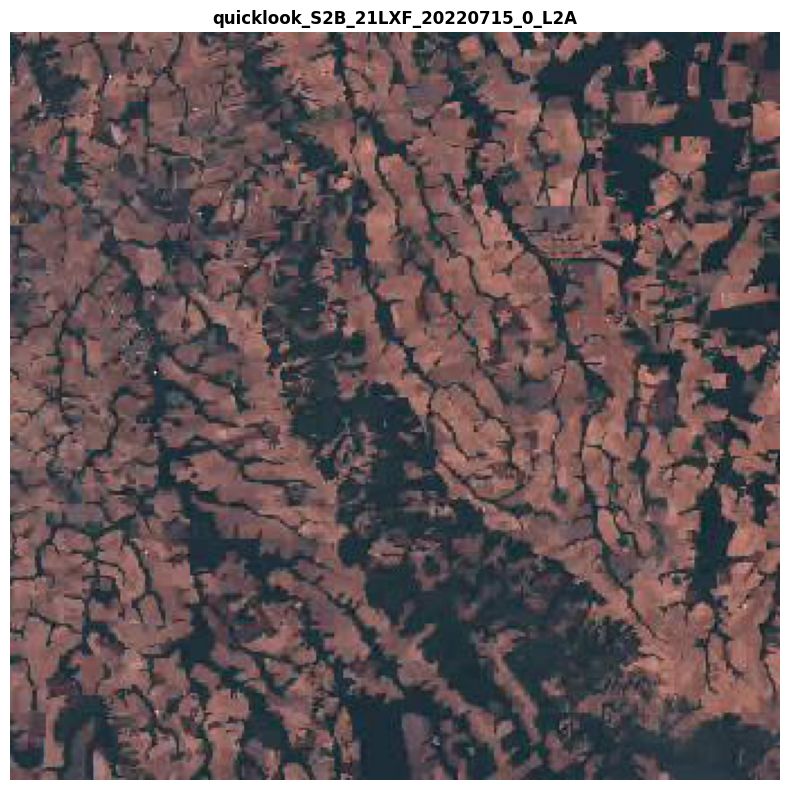

In [28]:
catalog.download_quicklooks(search_results.iloc[max_limit_items-1].id, collection='sentinel-2')
catalog.plot_quicklooks()

In [29]:
list_order_parameters = []

In [30]:
for k in range(search_results.shape[0]):
  list_order_parameters.append(catalog.construct_order_parameters(
                                        data_product_id=data_product_id,
                                        image_id=search_results.iloc[k]["id"],
    ))


2023-12-11 08:01:48,292 - See `catalog.get_data_product_schema(data_product_id)` for more detail on the parameter options.
2023-12-11 08:01:49,450 - See `catalog.get_data_product_schema(data_product_id)` for more detail on the parameter options.
2023-12-11 08:01:49,848 - See `catalog.get_data_product_schema(data_product_id)` for more detail on the parameter options.
2023-12-11 08:01:50,243 - See `catalog.get_data_product_schema(data_product_id)` for more detail on the parameter options.


In [ ]:
for k in range(search_results.shape[0]):
  print(catalog.place_order((list_order_parameters[k]), track_status=True))

2023-12-10 23:55:07,942 - Order is PLACED
2023-12-10 23:55:07,944 - Order c6eab6f6-48ea-49e0-a3d5-3fab6b97d2b5 is now PLACED.
2023-12-10 23:55:07,946 - Tracking order status, reporting every 120 seconds...
2023-12-10 23:55:08,419 - Order is PLACED
2023-12-10 23:55:08,693 - Order is PLACED
2023-12-10 23:57:09,591 - Order is BEING_FULFILLED
2023-12-10 23:57:10,070 - Order is BEING_FULFILLED
2023-12-10 23:57:10,548 - Order is BEING_FULFILLED! - c6eab6f6-48ea-49e0-a3d5-3fab6b97d2b5
2023-12-10 23:57:10,549 - 
2023-12-10 23:59:11,230 - Order is BEING_FULFILLED
2023-12-10 23:59:11,791 - Order is BEING_FULFILLED
2023-12-10 23:59:12,269 - Order is BEING_FULFILLED! - c6eab6f6-48ea-49e0-a3d5-3fab6b97d2b5
2023-12-10 23:59:12,272 - 
2023-12-11 00:01:14,554 - Order is FULFILLED
2023-12-11 00:01:14,557 - Order is fulfilled successfully! - c6eab6f6-48ea-49e0-a3d5-3fab6b97d2b5
2023-12-11 00:01:15,151 - Order is FULFILLED


Order(order_id: c6eab6f6-48ea-49e0-a3d5-3fab6b97d2b5, assets: ['6f28f26c-26a5-497b-a52a-16c1e0a79e54'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-10T23:55:05.363438Z, updatedAt: 2023-12-11T00:00:01.256911Z)


2023-12-11 00:01:19,386 - Order is PLACED
2023-12-11 00:01:19,388 - Order cf21803f-206c-4606-834d-5365120a1145 is now PLACED.
2023-12-11 00:01:19,389 - Tracking order status, reporting every 120 seconds...
2023-12-11 00:01:19,866 - Order is PLACED
2023-12-11 00:01:20,345 - Order is PLACED
2023-12-11 00:03:21,233 - Order is BEING_FULFILLED
2023-12-11 00:03:21,791 - Order is BEING_FULFILLED
2023-12-11 00:03:22,336 - Order is BEING_FULFILLED! - cf21803f-206c-4606-834d-5365120a1145
2023-12-11 00:03:22,339 - 
2023-12-11 00:05:22,932 - Order is BEING_FULFILLED
2023-12-11 00:05:23,431 - Order is BEING_FULFILLED
2023-12-11 00:05:23,904 - Order is BEING_FULFILLED! - cf21803f-206c-4606-834d-5365120a1145
2023-12-11 00:05:23,906 - 
2023-12-11 00:07:26,104 - Order is FULFILLED
2023-12-11 00:07:26,106 - Order is fulfilled successfully! - cf21803f-206c-4606-834d-5365120a1145
2023-12-11 00:07:26,585 - Order is FULFILLED


Order(order_id: cf21803f-206c-4606-834d-5365120a1145, assets: ['2b1479c5-32cb-4306-9387-a6d4c97ca800'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-11T00:01:16.686110Z, updatedAt: 2023-12-11T00:05:25.666187Z)


2023-12-11 00:07:30,307 - Order is PLACED
2023-12-11 00:07:30,309 - Order ff8159e5-6637-416e-bb00-985a9338dda5 is now PLACED.
2023-12-11 00:07:30,310 - Tracking order status, reporting every 120 seconds...
2023-12-11 00:07:30,797 - Order is PLACED
2023-12-11 00:07:31,264 - Order is PLACED
2023-12-11 00:09:32,283 - Order is BEING_FULFILLED
2023-12-11 00:09:32,753 - Order is BEING_FULFILLED
2023-12-11 00:09:33,229 - Order is BEING_FULFILLED! - ff8159e5-6637-416e-bb00-985a9338dda5
2023-12-11 00:09:33,231 - 
2023-12-11 00:11:33,976 - Order is BEING_FULFILLED
2023-12-11 00:11:34,525 - Order is BEING_FULFILLED
2023-12-11 00:11:35,077 - Order is BEING_FULFILLED! - ff8159e5-6637-416e-bb00-985a9338dda5
2023-12-11 00:11:35,080 - 
2023-12-11 00:13:37,309 - Order is FULFILLED
2023-12-11 00:13:37,311 - Order is fulfilled successfully! - ff8159e5-6637-416e-bb00-985a9338dda5
2023-12-11 00:13:37,784 - Order is FULFILLED


Order(order_id: ff8159e5-6637-416e-bb00-985a9338dda5, assets: ['dea5cfc4-167e-4526-b30c-5cf796545b65'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-11T00:07:27.774015Z, updatedAt: 2023-12-11T00:12:57.820124Z)


2023-12-11 00:13:41,808 - Order is PLACED
2023-12-11 00:13:41,811 - Order 389f67d3-6fbd-452a-b3c1-a7850147b77a is now PLACED.
2023-12-11 00:13:41,813 - Tracking order status, reporting every 120 seconds...
2023-12-11 00:13:42,433 - Order is PLACED
2023-12-11 00:13:42,973 - Order is PLACED
2023-12-11 00:15:44,137 - Order is BEING_FULFILLED
2023-12-11 00:15:44,616 - Order is BEING_FULFILLED
2023-12-11 00:15:45,092 - Order is BEING_FULFILLED! - 389f67d3-6fbd-452a-b3c1-a7850147b77a
2023-12-11 00:15:45,094 - 
2023-12-11 00:17:45,664 - Order is BEING_FULFILLED
2023-12-11 00:17:46,133 - Order is BEING_FULFILLED
2023-12-11 00:17:46,635 - Order is BEING_FULFILLED! - 389f67d3-6fbd-452a-b3c1-a7850147b77a
2023-12-11 00:17:46,637 - 
2023-12-11 00:19:49,253 - Order is FULFILLED
2023-12-11 00:19:49,255 - Order is fulfilled successfully! - 389f67d3-6fbd-452a-b3c1-a7850147b77a
2023-12-11 00:19:49,738 - Order is FULFILLED


Order(order_id: 389f67d3-6fbd-452a-b3c1-a7850147b77a, assets: ['416279f0-dbbf-48f6-8d54-c99f280a0ba0'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-11T00:13:39.201107Z, updatedAt: 2023-12-11T00:19:08.932783Z)


2023-12-11 00:19:53,542 - Order is PLACED
2023-12-11 00:19:53,545 - Order e0e34171-6f5d-4fdb-b5dd-8afde8dad687 is now PLACED.
2023-12-11 00:19:53,546 - Tracking order status, reporting every 120 seconds...
2023-12-11 00:19:54,018 - Order is PLACED
2023-12-11 00:19:54,502 - Order is PLACED
2023-12-11 00:21:55,588 - Order is BEING_FULFILLED
2023-12-11 00:21:56,073 - Order is BEING_FULFILLED
2023-12-11 00:21:56,543 - Order is BEING_FULFILLED! - e0e34171-6f5d-4fdb-b5dd-8afde8dad687
2023-12-11 00:21:56,546 - 
2023-12-11 00:23:57,222 - Order is BEING_FULFILLED
2023-12-11 00:23:57,761 - Order is BEING_FULFILLED
2023-12-11 00:23:58,305 - Order is BEING_FULFILLED! - e0e34171-6f5d-4fdb-b5dd-8afde8dad687
2023-12-11 00:23:58,308 - 
2023-12-11 00:26:00,503 - Order is FULFILLED
2023-12-11 00:26:00,504 - Order is fulfilled successfully! - e0e34171-6f5d-4fdb-b5dd-8afde8dad687
2023-12-11 00:26:00,982 - Order is FULFILLED


Order(order_id: e0e34171-6f5d-4fdb-b5dd-8afde8dad687, assets: ['1f7b603f-9ad0-482b-8064-1c139fb002d7'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-11T00:19:51.012354Z, updatedAt: 2023-12-11T00:25:16.906445Z)


2023-12-11 00:26:04,842 - Order is PLACED
2023-12-11 00:26:04,852 - Order 23223404-e99c-45d4-9e8a-afe3ad93629b is now PLACED.
2023-12-11 00:26:04,854 - Tracking order status, reporting every 120 seconds...
2023-12-11 00:26:05,392 - Order is PLACED
2023-12-11 00:26:05,948 - Order is PLACED
2023-12-11 00:28:07,083 - Order is BEING_FULFILLED
2023-12-11 00:28:07,576 - Order is BEING_FULFILLED
2023-12-11 00:28:08,060 - Order is BEING_FULFILLED! - 23223404-e99c-45d4-9e8a-afe3ad93629b
2023-12-11 00:28:08,062 - 
2023-12-11 00:30:08,702 - Order is BEING_FULFILLED
2023-12-11 00:30:09,174 - Order is BEING_FULFILLED
2023-12-11 00:30:09,646 - Order is BEING_FULFILLED! - 23223404-e99c-45d4-9e8a-afe3ad93629b
2023-12-11 00:30:09,649 - 
2023-12-11 00:32:12,053 - Order is FULFILLED
2023-12-11 00:32:12,056 - Order is fulfilled successfully! - 23223404-e99c-45d4-9e8a-afe3ad93629b
2023-12-11 00:32:12,597 - Order is FULFILLED


Order(order_id: 23223404-e99c-45d4-9e8a-afe3ad93629b, assets: ['203bb86f-35a2-44a8-87cd-e628f7ed7f80'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-11T00:26:02.196143Z, updatedAt: 2023-12-11T00:31:08.685482Z)


2023-12-11 00:32:16,202 - Order is PLACED
2023-12-11 00:32:16,204 - Order c19e14ff-9db4-485b-ab1d-4b78374bded3 is now PLACED.
2023-12-11 00:32:16,206 - Tracking order status, reporting every 120 seconds...
2023-12-11 00:32:16,684 - Order is PLACED
2023-12-11 00:32:16,951 - Order is PLACED
2023-12-11 00:34:18,129 - Order is BEING_FULFILLED
2023-12-11 00:34:18,697 - Order is BEING_FULFILLED
2023-12-11 00:34:19,231 - Order is BEING_FULFILLED! - c19e14ff-9db4-485b-ab1d-4b78374bded3
2023-12-11 00:34:19,233 - 
2023-12-11 00:36:19,809 - Order is BEING_FULFILLED
2023-12-11 00:36:20,290 - Order is BEING_FULFILLED
2023-12-11 00:36:20,760 - Order is BEING_FULFILLED! - c19e14ff-9db4-485b-ab1d-4b78374bded3
2023-12-11 00:36:20,764 - 
2023-12-11 00:38:22,939 - Order is FULFILLED
2023-12-11 00:38:22,941 - Order is fulfilled successfully! - c19e14ff-9db4-485b-ab1d-4b78374bded3
2023-12-11 00:38:23,423 - Order is FULFILLED


Order(order_id: c19e14ff-9db4-485b-ab1d-4b78374bded3, assets: ['83681ace-d6b2-4d5f-a462-254aaa9dbd5f'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-11T00:32:13.726001Z, updatedAt: 2023-12-11T00:36:48.540682Z)


2023-12-11 00:38:27,474 - Order is PLACED
2023-12-11 00:38:27,475 - Order 5b4fc9f9-7185-4d00-8ebe-d26e069c6047 is now PLACED.
2023-12-11 00:38:27,478 - Tracking order status, reporting every 120 seconds...
2023-12-11 00:38:27,949 - Order is PLACED
2023-12-11 00:38:28,496 - Order is PLACED
2023-12-11 00:40:29,417 - Order is BEING_FULFILLED
2023-12-11 00:40:29,894 - Order is BEING_FULFILLED
2023-12-11 00:40:30,367 - Order is BEING_FULFILLED! - 5b4fc9f9-7185-4d00-8ebe-d26e069c6047
2023-12-11 00:40:30,370 - 
2023-12-11 00:42:31,040 - Order is BEING_FULFILLED
2023-12-11 00:42:31,535 - Order is BEING_FULFILLED
2023-12-11 00:42:32,006 - Order is BEING_FULFILLED! - 5b4fc9f9-7185-4d00-8ebe-d26e069c6047
2023-12-11 00:42:32,008 - 
2023-12-11 00:44:34,255 - Order is FULFILLED
2023-12-11 00:44:34,257 - Order is fulfilled successfully! - 5b4fc9f9-7185-4d00-8ebe-d26e069c6047
2023-12-11 00:44:34,593 - Order is FULFILLED


Order(order_id: 5b4fc9f9-7185-4d00-8ebe-d26e069c6047, assets: ['81fd0baf-3283-40a8-ba13-9aa3b2085f4c'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-11T00:38:24.896410Z, updatedAt: 2023-12-11T00:43:54.013722Z)


2023-12-11 00:44:38,697 - Order is PLACED
2023-12-11 00:44:38,699 - Order b3de5504-68a7-410c-b370-8575ae739354 is now PLACED.
2023-12-11 00:44:38,701 - Tracking order status, reporting every 120 seconds...
2023-12-11 00:44:39,169 - Order is PLACED
2023-12-11 00:44:39,649 - Order is PLACED
2023-12-11 00:46:40,797 - Order is BEING_FULFILLED
2023-12-11 00:46:41,345 - Order is BEING_FULFILLED
2023-12-11 00:46:41,881 - Order is BEING_FULFILLED! - b3de5504-68a7-410c-b370-8575ae739354
2023-12-11 00:46:41,884 - 
2023-12-11 00:48:42,452 - Order is BEING_FULFILLED
2023-12-11 00:48:42,933 - Order is BEING_FULFILLED
2023-12-11 00:48:43,418 - Order is BEING_FULFILLED! - b3de5504-68a7-410c-b370-8575ae739354
2023-12-11 00:48:43,420 - 
2023-12-11 00:50:45,551 - Order is FULFILLED
2023-12-11 00:50:45,552 - Order is fulfilled successfully! - b3de5504-68a7-410c-b370-8575ae739354
2023-12-11 00:50:46,049 - Order is FULFILLED


Order(order_id: b3de5504-68a7-410c-b370-8575ae739354, assets: ['d2c9be4a-5487-419b-8e9a-e97de9dca50a'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-11T00:44:36.165210Z, updatedAt: 2023-12-11T00:49:51.305847Z)


2023-12-11 00:50:49,569 - Order is PLACED
2023-12-11 00:50:49,571 - Order 2ea6eca7-9618-4e5d-87fe-efb564ee4b7e is now PLACED.
2023-12-11 00:50:49,574 - Tracking order status, reporting every 120 seconds...
2023-12-11 00:50:50,047 - Order is PLACED
2023-12-11 00:50:50,527 - Order is PLACED
2023-12-11 00:52:51,512 - Order is BEING_FULFILLED
2023-12-11 00:52:51,986 - Order is BEING_FULFILLED
2023-12-11 00:52:52,467 - Order is BEING_FULFILLED! - 2ea6eca7-9618-4e5d-87fe-efb564ee4b7e
2023-12-11 00:52:52,469 - 
2023-12-11 00:54:53,101 - Order is BEING_FULFILLED
2023-12-11 00:54:53,656 - Order is BEING_FULFILLED
2023-12-11 00:54:54,195 - Order is BEING_FULFILLED! - 2ea6eca7-9618-4e5d-87fe-efb564ee4b7e
2023-12-11 00:54:54,198 - 
2023-12-11 00:56:56,421 - Order is FULFILLED
2023-12-11 00:56:56,423 - Order is fulfilled successfully! - 2ea6eca7-9618-4e5d-87fe-efb564ee4b7e
2023-12-11 00:56:56,906 - Order is FULFILLED


Order(order_id: 2ea6eca7-9618-4e5d-87fe-efb564ee4b7e, assets: ['1d887950-3a2a-4364-a876-e4932739746d'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-11T00:50:47.260051Z, updatedAt: 2023-12-11T00:55:48.109287Z)


2023-12-11 00:57:00,480 - Order is PLACED
2023-12-11 00:57:00,483 - Order 6c2b3820-0281-423c-93f5-60ec7d867299 is now PLACED.
2023-12-11 00:57:00,487 - Tracking order status, reporting every 120 seconds...
2023-12-11 00:57:01,047 - Order is PLACED
2023-12-11 00:57:01,578 - Order is PLACED
2023-12-11 00:59:02,660 - Order is BEING_FULFILLED
2023-12-11 00:59:03,212 - Order is BEING_FULFILLED
2023-12-11 00:59:03,482 - Order is BEING_FULFILLED! - 6c2b3820-0281-423c-93f5-60ec7d867299
2023-12-11 00:59:03,484 - 
2023-12-11 01:01:04,123 - Order is BEING_FULFILLED
2023-12-11 01:01:04,612 - Order is BEING_FULFILLED
2023-12-11 01:01:05,081 - Order is BEING_FULFILLED! - 6c2b3820-0281-423c-93f5-60ec7d867299
2023-12-11 01:01:05,083 - 
2023-12-11 01:03:07,486 - Order is FULFILLED
2023-12-11 01:03:07,488 - Order is fulfilled successfully! - 6c2b3820-0281-423c-93f5-60ec7d867299
2023-12-11 01:03:07,967 - Order is FULFILLED


Order(order_id: 6c2b3820-0281-423c-93f5-60ec7d867299, assets: ['c23c623f-aaf9-4045-8dc5-456431923b5f'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-11T00:56:58.109497Z, updatedAt: 2023-12-11T01:02:07.144292Z)


2023-12-11 01:03:11,895 - Order is PLACED
2023-12-11 01:03:11,898 - Order 5409a9d3-e284-4c55-a4bd-3f4982b4eeaf is now PLACED.
2023-12-11 01:03:11,901 - Tracking order status, reporting every 120 seconds...
2023-12-11 01:03:12,377 - Order is PLACED
2023-12-11 01:03:12,866 - Order is PLACED
2023-12-11 01:05:13,916 - Order is BEING_FULFILLED
2023-12-11 01:05:14,182 - Order is BEING_FULFILLED
2023-12-11 01:05:14,655 - Order is BEING_FULFILLED! - 5409a9d3-e284-4c55-a4bd-3f4982b4eeaf
2023-12-11 01:05:14,657 - 
2023-12-11 01:07:15,250 - Order is BEING_FULFILLED
2023-12-11 01:07:15,742 - Order is BEING_FULFILLED
2023-12-11 01:07:16,286 - Order is BEING_FULFILLED! - 5409a9d3-e284-4c55-a4bd-3f4982b4eeaf
2023-12-11 01:07:16,288 - 
2023-12-11 01:09:18,380 - Order is FULFILLED
2023-12-11 01:09:18,381 - Order is fulfilled successfully! - 5409a9d3-e284-4c55-a4bd-3f4982b4eeaf
2023-12-11 01:09:18,854 - Order is FULFILLED


Order(order_id: 5409a9d3-e284-4c55-a4bd-3f4982b4eeaf, assets: ['38e6e711-6deb-4976-9e98-17c6f1e7ad16'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-11T01:03:09.342676Z, updatedAt: 2023-12-11T01:07:39.554948Z)


2023-12-11 01:09:22,949 - Order is PLACED
2023-12-11 01:09:22,952 - Order dc3925d9-4864-4460-aae9-ba763041fbed is now PLACED.
2023-12-11 01:09:22,954 - Tracking order status, reporting every 120 seconds...
2023-12-11 01:09:23,500 - Order is PLACED
2023-12-11 01:09:23,837 - Order is PLACED
2023-12-11 01:11:24,997 - Order is BEING_FULFILLED
2023-12-11 01:11:25,465 - Order is BEING_FULFILLED
2023-12-11 01:11:25,949 - Order is BEING_FULFILLED! - dc3925d9-4864-4460-aae9-ba763041fbed
2023-12-11 01:11:25,951 - 
2023-12-11 01:13:26,582 - Order is BEING_FULFILLED
2023-12-11 01:13:27,088 - Order is BEING_FULFILLED
2023-12-11 01:13:27,566 - Order is BEING_FULFILLED! - dc3925d9-4864-4460-aae9-ba763041fbed
2023-12-11 01:13:27,569 - 
2023-12-11 01:15:30,008 - Order is FULFILLED
2023-12-11 01:15:30,011 - Order is fulfilled successfully! - dc3925d9-4864-4460-aae9-ba763041fbed
2023-12-11 01:15:30,560 - Order is FULFILLED


Order(order_id: dc3925d9-4864-4460-aae9-ba763041fbed, assets: ['6397664e-3904-454f-938a-68a16e8c0b23'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-11T01:09:20.260980Z, updatedAt: 2023-12-11T01:13:42.880605Z)


2023-12-11 01:15:34,698 - Order is PLACED
2023-12-11 01:15:34,699 - Order 3db7759f-515c-4823-a480-71bb642bfaca is now PLACED.
2023-12-11 01:15:34,701 - Tracking order status, reporting every 120 seconds...
2023-12-11 01:15:35,179 - Order is PLACED
2023-12-11 01:15:35,651 - Order is PLACED
2023-12-11 01:17:36,826 - Order is BEING_FULFILLED
2023-12-11 01:17:37,155 - Order is BEING_FULFILLED
2023-12-11 01:17:37,703 - Order is BEING_FULFILLED! - 3db7759f-515c-4823-a480-71bb642bfaca
2023-12-11 01:17:37,705 - 
2023-12-11 01:19:38,281 - Order is BEING_FULFILLED
2023-12-11 01:19:38,769 - Order is BEING_FULFILLED
2023-12-11 01:19:39,240 - Order is BEING_FULFILLED! - 3db7759f-515c-4823-a480-71bb642bfaca
2023-12-11 01:19:39,242 - 
2023-12-11 01:21:41,420 - Order is FULFILLED
2023-12-11 01:21:41,422 - Order is fulfilled successfully! - 3db7759f-515c-4823-a480-71bb642bfaca
2023-12-11 01:21:41,911 - Order is FULFILLED


Order(order_id: 3db7759f-515c-4823-a480-71bb642bfaca, assets: ['7b9d764d-e9b5-4936-a0bd-a39247693a9f'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-11T01:15:32.146954Z, updatedAt: 2023-12-11T01:20:08.068600Z)


2023-12-11 01:21:45,636 - Order is PLACED
2023-12-11 01:21:45,642 - Order e061ddb4-18aa-4a1e-b054-4923cd3324c0 is now PLACED.
2023-12-11 01:21:45,647 - Tracking order status, reporting every 120 seconds...
2023-12-11 01:21:46,125 - Order is PLACED
2023-12-11 01:21:46,601 - Order is PLACED
2023-12-11 01:23:47,667 - Order is BEING_FULFILLED
2023-12-11 01:23:48,151 - Order is BEING_FULFILLED
2023-12-11 01:23:48,634 - Order is BEING_FULFILLED! - e061ddb4-18aa-4a1e-b054-4923cd3324c0
2023-12-11 01:23:48,637 - 
2023-12-11 01:25:49,342 - Order is BEING_FULFILLED
2023-12-11 01:25:49,812 - Order is BEING_FULFILLED
2023-12-11 01:25:50,328 - Order is BEING_FULFILLED! - e061ddb4-18aa-4a1e-b054-4923cd3324c0
2023-12-11 01:25:50,331 - 
2023-12-11 01:27:52,554 - Order is FULFILLED
2023-12-11 01:27:52,557 - Order is fulfilled successfully! - e061ddb4-18aa-4a1e-b054-4923cd3324c0
2023-12-11 01:27:53,150 - Order is FULFILLED


Order(order_id: e061ddb4-18aa-4a1e-b054-4923cd3324c0, assets: ['b8f1f630-cf47-4220-b554-7672e70f0caa'], dataProvider: None, status: FULFILLED, createdAt: 2023-12-11T01:21:43.059136Z, updatedAt: 2023-12-11T01:26:48.809826Z)


2023-12-11 01:27:57,185 - Order is PLACED
2023-12-11 01:27:57,188 - Order 8bcf3987-6087-4ee9-8651-f01ba56bb522 is now PLACED.
2023-12-11 01:27:57,191 - Tracking order status, reporting every 120 seconds...
2023-12-11 01:27:57,668 - Order is PLACED
2023-12-11 01:27:58,148 - Order is PLACED
2023-12-11 01:29:59,256 - Order is BEING_FULFILLED


KeyboardInterrupt: ignored

# Access UP42 Storage & Automate download


In [33]:
# authenticate with UP42

_UP42_AUTH_URL: Final[str] = "https://api.up42.com/oauth/token"

client_auth = OAuth2ClientCredentials(
                _UP42_AUTH_URL,
                client_id=api_credentials["project_id"],
                client_secret=api_credentials["project_api_key"],
            )


In [34]:
# auxilary functions

def up42_asset_stac_url(url: str) -> str:
    """Create a UP42 Spatial Asset service URL."""
    return f"https://api.up42.com/v2/assets/stac{url}"

def ppjson(json_data: dict, expand:bool=True) -> DisplayObject:
    """Pretty print JSON data."""
    return JSON(json_data, expanded=expand)


In [36]:
def search_item(req_body:dict) -> httpx.Response:
    """Searches for a STAC item according to the given criteria."""
    return httpx.post(up42_asset_stac_url("/search"),
                      headers={"content-type":"application/json"},
                      auth=client_auth,
                      json=req_body)

# Complex searches

In [37]:
path2geom = os.path.join(data_folder, "amazonas.geojson")

In [38]:
with open(path2geom, "r") as f:
    geom_map = json.load(f)

In [41]:
shape_geom_map = shape(get_in(["features", 0, "geometry"], geom_map))

In [42]:
intersect_map_center = shape_geom_map.centroid

In [43]:
intersect_map = Map(center=(intersect_map_center.y, intersect_map_center.x), zoom=6)

# Add the AOI to the map. First style it and then add it.
intersect_layer = GeoJSON(
    data=geom_map,
    style={"opacity": 1, "dashArray": "9", "fillOpacity": 0.5, "weight": 1},
    hover_style={"color": "yellow", "dashArray": "0", "fillOpacity": 0.5},
)
# Add a marker layer at the center.
intersect_marker_layer = Marker(location=(intersect_map_center.y, intersect_map_center.x),
                                draggable=False, icon=AwesomeIcon(name="close",
                                                                  color_marker="green"))
intersect_map.add_layer(intersect_layer)
intersect_map.add_layer(intersect_marker_layer)
intersect_map

Map(center=[-13.38348533111755, -55.66331848845795], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [52]:
intersect_req_body = dict(intersects = mapping(shape_geom_map))

In [51]:
my_cloud_cover_dict = dict(filter=dict(args=[
    dict(property="eo:cloud_cover"), 10],
    op="<"))

In [50]:
new_intersect_req_body = intersect_req_body | my_cloud_cover_dict

In [47]:
complex_search_results = search_item(new_intersect_req_body).json()
ppjson(complex_search_results)

<IPython.core.display.JSON object>

In [49]:
cloud_cover_workspace_dict = dict(filter=
     dict(args=[
             dict(args=[dict(property="eo:cloud_cover"), 10],
                  op="<"),
             dict(args=[dict(property="workspace_id"), api_credentials['workspace_id']],
                  op="=")],
          op="and")
    )

In [53]:
complex_search_results = search_item(intersect_req_body | cloud_cover_workspace_dict).json()
ppjson(complex_search_results, expand = True)


<IPython.core.display.JSON object>

In [58]:
limit_dict = dict(limit = max_limit_items)
complex_search_results_max_limit = search_item(intersect_req_body | cloud_cover_workspace_dict | limit_dict).json()
ppjson(complex_search_results_max_limit, expand = True)

<IPython.core.display.JSON object>

In [55]:
complex_search_results_layer = GeoJSON(data=complex_search_results,
                                       style={"color":"red",  "opacity": 1,
                                              "dashArray": "9", "fillOpacity": 0.5,
                                              "weight": 1},
    hover_style={"color": "white", "dashArray": "0", "fillOpacity": 0.5},
)
intersect_map.add_layer(complex_search_results_layer)
intersect_map

Map(bottom=9007.0, center=[-13.38348533111755, -55.66331848845795], controls=(ZoomControl(options=['position',…

# Downloading the assets

In [56]:
complex_search_asset_ids = list(map(lambda e: get_in(["properties", "up42-system:asset_id"], e),
                                    complex_search_results["features"]))
complex_search_asset_ids

['82682b4e-a835-4639-84d6-b8208cbf9462',
 'ff828cf7-b3eb-4f5e-beaf-959f3ea1941d',
 'abb88835-d139-477b-bfa8-ac5e9bcb3bf3',
 '20984191-c197-4612-b938-19993011b65b',
 '3d639415-ff9c-4008-83a2-4f727ece3a00',
 '91e44249-a3f7-4b5f-a521-ce628363853b',
 'e43ecca8-1408-49de-868f-f9429b2494e4',
 '66a44e7e-7094-495a-a502-04c98ed72094',
 'd0a7b6cd-a45a-4734-86ca-7c106b7c5e88',
 '75dffe11-3959-4de5-959e-8becb658c7a5']

In [59]:
complex_search_results_max_limit_asset_ids = list(map(lambda e: get_in(["properties", "up42-system:asset_id"], e),
                                    complex_search_results_max_limit["features"]))
complex_search_results_max_limit_asset_ids

['82682b4e-a835-4639-84d6-b8208cbf9462',
 'ff828cf7-b3eb-4f5e-beaf-959f3ea1941d',
 'abb88835-d139-477b-bfa8-ac5e9bcb3bf3',
 '20984191-c197-4612-b938-19993011b65b']

In [60]:
def download_asset(url, path) -> None:
    """Downloads an asset with the given ID."""
    with open(path, 'wb') as output:
        with httpx.stream("GET",
                          url,
                          auth=client_auth, follow_redirects=True) as r:
            for data in r.iter_bytes():
                output.write(data)

In [61]:
asset_dir = os.path.join(data_folder , "S2/")

In [62]:
for i in range(len(complex_search_results_max_limit_asset_ids)):
  try:

    print(complex_search_results["features"][i]['properties']['datetime'].split('T')[0])

    path = os.path.join(asset_dir,
                      complex_search_results_max_limit["features"][i]['properties']['datetime'].split('T')[0])
    os.mkdir(path)

    b04_url = (complex_search_results_max_limit["features"][i]['assets']['b04.tiff']['href'])
    b08_url = (complex_search_results_max_limit["features"][i]['assets']['b08.tiff']['href'])

    file_path_b04 = os.path.join(path, 'b04.tiff')
    file_path_b08 = os.path.join(path, 'b08.tiff')

    download_asset(b04_url, file_path_b04)
    download_asset(b08_url, file_path_b08)

    print('**********************************************')
  except FileExistsError:
    continue


2022-07-25
**********************************************
2022-07-30
2022-07-30
2022-07-05
**********************************************


# Create NDVI time series & Visulaze

In [63]:
def paths_to_datetimeindex(paths, string_slice=(0, 10)):
    """
    Helper function to generate a Pandas datetimeindex object
    from dates contained in a file path string.

    Parameters
    ----------
    paths : list of strings
        A list of file path strings that will be used to extract times
    string_slice : tuple
        An optional tuple giving the start and stop position that
        contains the time information in the provided paths. These are
        applied to the basename (i.e. file name) in each path, not the
        path itself. Defaults to (0, 10).

    Returns
    -------
    datetime : pandas.DatetimeIndex
        A pandas.DatetimeIndex object containing a 'datetime64[ns]' derived
        from the file paths provided by `paths`.
    """

    date_strings = [os.path.basename(os.path.dirname(i)) for i in paths]
    return pd.to_datetime(date_strings)

## Crop the rasters to AOI extent

In [65]:
# WGS84 coordinates
minx, miny = -55.80602463366668, -13.49938970772358,

maxx, maxy = -55.520612343249226, -13.267580954511516,

bbox = box(minx, miny, maxx, maxy)

In [66]:
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))

In [68]:
# Project the Polygon into same CRS as the grid
geo = geo.to_crs(crs=CRS.from_epsg(32721))

In [69]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]


In [70]:
coords = getFeatures(geo)

In [72]:
def crop_raster(asset_dir, coords, band):
  file_path = os.path.join(asset_dir, f'{band}.tiff')

  with rasterio.open(file_path) as data:
    out_img, out_transform = rasterio.mask.mask(dataset=data, shapes=coords, crop=True)
    out_meta = data.meta
    epsg_code = int(data.crs.data['init'][5:])

    out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform})
    # Output raster
    out_path = os.path.join(asset_dir, f"out_tif_{band}.tif")

    with rasterio.open(out_path, "w", **out_meta) as dest:
      dest.write(out_img)

In [76]:
for i in os.listdir(asset_dir):
  print(os.path.join(asset_dir, i))
  crop_raster(os.path.join(asset_dir, i), coords, 'b04')
  crop_raster(os.path.join(asset_dir, i), coords, 'b08')


/content/drive/MyDrive/Professional-Developement-Courses/Portfolio_Notebooks/UP42_challenge/S2/2022-06-30
/content/drive/MyDrive/Professional-Developement-Courses/Portfolio_Notebooks/UP42_challenge/S2/2022-07-15
/content/drive/MyDrive/Professional-Developement-Courses/Portfolio_Notebooks/UP42_challenge/S2/2022-07-30
/content/drive/MyDrive/Professional-Developement-Courses/Portfolio_Notebooks/UP42_challenge/S2/2022-05-11
/content/drive/MyDrive/Professional-Developement-Courses/Portfolio_Notebooks/UP42_challenge/S2/2022-05-31
/content/drive/MyDrive/Professional-Developement-Courses/Portfolio_Notebooks/UP42_challenge/S2/2022-06-05


##Create datacube

In [77]:
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

In [78]:
def prep_bands_datacube(parent_dir, date, band):
  '''
  band = 'b04' or 'b08'
  '''
  asset_item_dir = os.path.join(asset_dir, date, f'out_tif_{band}.tif')
  data_band = rasterio.open(asset_item_dir).read(1)
  data_band_normalized = normalize(data_band)

  data_array_band_normalized = xr.DataArray(data = data_band_normalized,
                                      dims=('x', 'y'),
                                      coords={'x': list(range(0, data_band_normalized.shape[0])),
                                              'y': list(range(0, data_band_normalized.shape[1]))})

  if(band == 'b04'):
    data_array_band_normalized.name = 'band4'
  elif(band == 'b08'):
    data_array_band_normalized.name = 'band8'

  return(data_array_band_normalized)


In [79]:
list_time=list()
for i in os.listdir(asset_dir):
  list_time.append(glob.glob((os.path.join(asset_dir, i, 'out_tif_b04.tif')),
                         recursive = True)[0])

In [80]:
list_data_array_merged_time = list()

for i in os.listdir(asset_dir):
  print(os.path.join(asset_dir, i))

  data_array_merged = xr.merge([prep_bands_datacube(asset_dir, i, 'b04'),
                               prep_bands_datacube(asset_dir, i, 'b08')])

  list_data_array_merged_time.append(data_array_merged)


/content/drive/MyDrive/Professional-Developement-Courses/Portfolio_Notebooks/UP42_challenge/S2/2022-06-30
/content/drive/MyDrive/Professional-Developement-Courses/Portfolio_Notebooks/UP42_challenge/S2/2022-07-15
/content/drive/MyDrive/Professional-Developement-Courses/Portfolio_Notebooks/UP42_challenge/S2/2022-07-30
/content/drive/MyDrive/Professional-Developement-Courses/Portfolio_Notebooks/UP42_challenge/S2/2022-05-11
/content/drive/MyDrive/Professional-Developement-Courses/Portfolio_Notebooks/UP42_challenge/S2/2022-05-31
/content/drive/MyDrive/Professional-Developement-Courses/Portfolio_Notebooks/UP42_challenge/S2/2022-06-05


In [81]:
ds_all = xr.concat(list_data_array_merged_time,
                   dim= xr.Variable('time', paths_to_datetimeindex(list_time))
)

In [82]:
ds_all['ndvi'] = (ds_all['band8'] - ds_all['band4'])/\
                 (ds_all['band8'] + ds_all['band4'])

In [85]:
# reindex datacube based on time
new_time = sorted(ds_all.time.values)
ds_all = ds_all.reindex(time = new_time)

In [ ]:
ds_all.band4.plot(col='time')

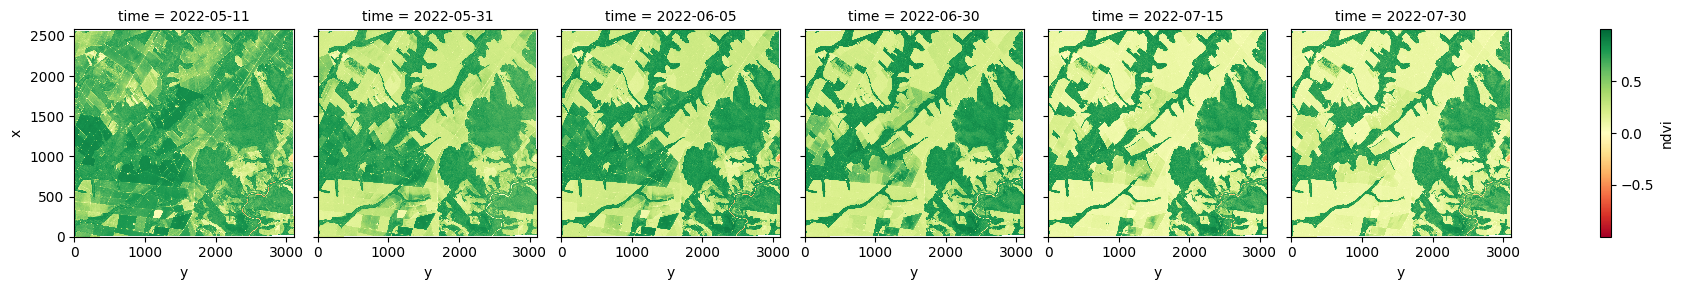

In [86]:
ds_all.ndvi.plot(col='time', cmap='RdYlGn')

In [87]:
point_x, point_y = 150, 1500

In [88]:
sentinel_point = ds_all.interp(x=point_x, y=point_y,
                               method="nearest")

In [89]:
sentinel_point

<xarray.Dataset>
Dimensions:  (time: 6)
Coordinates:
  * time     (time) datetime64[ns] 2022-05-11 2022-05-31 ... 2022-07-30
    x        int64 150
    y        int64 1500
Data variables:
    band4    (time) float64 0.06822 0.07292 0.06533 0.07487 0.1346 0.2956
    band8    (time) float64 0.9179 0.9311 0.9169 0.7813 0.5299 0.4561
    ndvi     (time) float64 0.8616 0.8548 0.867 0.8251 0.5949 0.2136

In [90]:
sentinel_table = sentinel_point.to_dataframe()

In [91]:
sentinel_table.head(3)

,band4,band8,ndvi,x,y
time,,,,,
2022-05-11,0.068219,0.917877,0.861639,150,1500
2022-05-31,0.072917,0.931106,0.854751,150,1500
2022-06-05,0.065326,0.916899,0.866984,150,1500


<Axes: xlabel='time'>

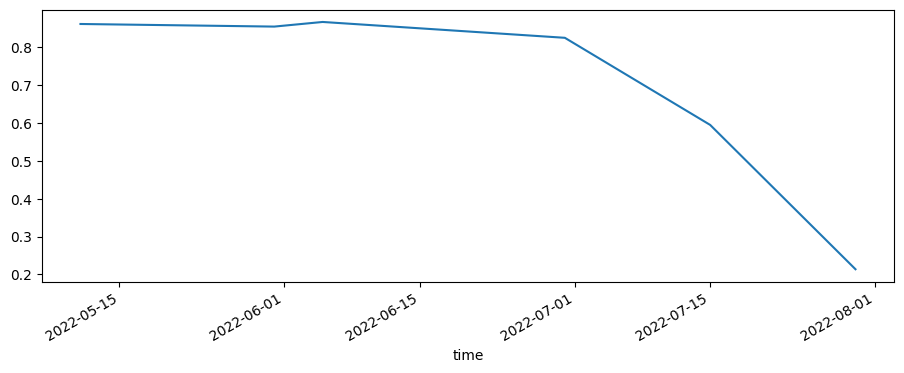

In [95]:
plt.figure(figsize=(11, 4))

sentinel_table['ndvi'].plot.line("b-^")

### Plot the vegetation index over time

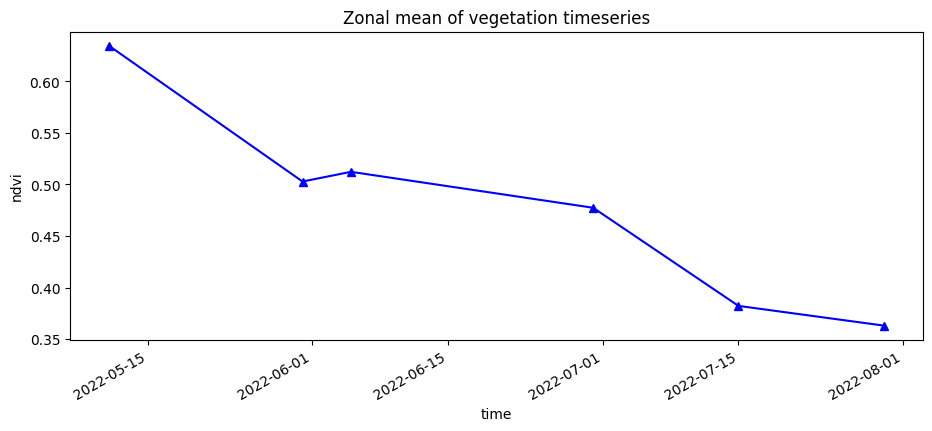

In [96]:
ds_all.ndvi.mean(['x', 'y']).plot.line('b-^', figsize=(11,4))
plt.title('Zonal mean of vegetation timeseries');